In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
                
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
                 
    return dot


In [22]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data * other.data, (self, other), '*')
    
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __pow__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data ** other.data, (self, other), '**')
        
        def _backward():
            self.grad += other.data * (self.data ** (other.data - 1)) * out.grad
            other.grad += math.log(self.data) * out.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def tanh(self):
        out = Value(math.tanh(self.data), (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - out.data * out.data) * out.grad
            
        out._backward = _backward
        
        return out
    
    def backprop(self):
        order = []
        visited = set()
        def build_topological_order(v):
            if v not in visited:
                v.grad = 0.0
                visited.add(v)
                
                for child in v._prev:
                    build_topological_order(child)
                    
                order.append(v)
        
        build_topological_order(self)
        
        self.grad = 1.0
        for node in reversed(order):
            node._backward()
        
        

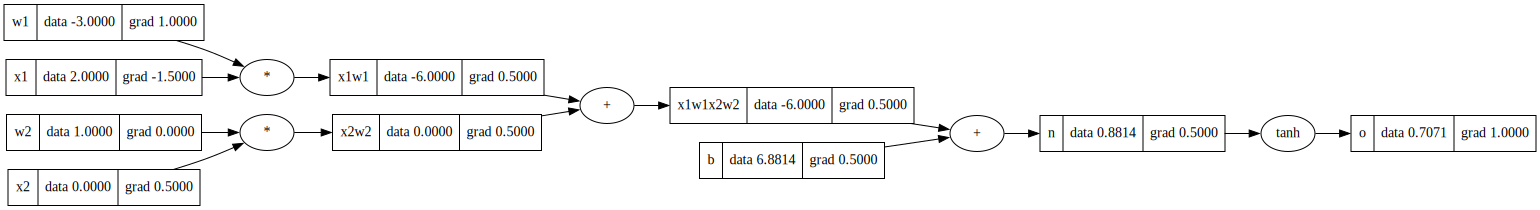

In [23]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

o.backprop()
draw_dot(o)

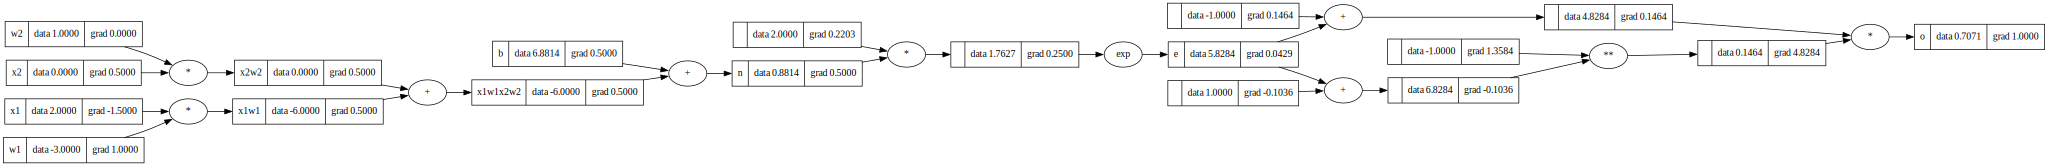

In [24]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp(); e.label = 'e'

o = (e - 1) / (e + 1); o.label = 'o'

o.backprop()
draw_dot(o)